In [1]:
# Загрузка биьлиотек
import pandas as pd
import sqlite3 as db

import datetime as dt
import multiprocessing
from multiprocessing import Pool, Manager

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import pprint
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from package.select_run_test import SampleComparisonTest

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# 3. Оценка эффективности первой рекламной кампании

## 3.1. Формирование данных AB-тестирования из  имеющихся источников

In [2]:
# Загрузим итоговый датаcет из хранилища
connection = db.connect('data/purchases.db')
print("База данных создана и подключена")
query = 'SELECT * FROM full_table'
df_all = pd.read_sql_query(query, connection)
print("Таблица заполнена")
connection.close()
print("Соединение с базой данных закрыто")

База данных создана и подключена
Таблица заполнена
Соединение с базой данных закрыто


## 3.2. Оценка первой рекламной кампании

In [3]:
# Прочитаем признаки проведения AB-тестов
# Загрузим признаки тестовой и контрольной выборок
def f_indexes(df, col, file_name, value):
    def f(x, y, value, indexes):
        if x in indexes:
            return value
        else:
            return y
    
    indexes = list()
    with open(file_name) as file:
        while True:
            line = file.readline()
            if not line:
                break
            row = line[:-1].replace(' ', ',').replace(';', ',').split(',')
            for elem in row:
                if elem.isdigit():
                    indexes.append(int(elem))
    
    # Оставим только уникальные значения индексов
    indexes = list(set(indexes))
    print(f'Количество записей {file_name[-12:-4]}: {len(indexes)}')

    df[col] = df.apply(lambda x: f(x.id, x[col], value, indexes), axis=1)

    return df

In [4]:
# Добавим в датасет признак тестовой группы
col = 'test'
df_all[col] = None

# Заполним признак данными о тестовой группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_positive.txt', 1)

# Заполним признак данными о контрольной группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_negative.txt', 0)

Количество записей positive: 5016
Количество записей negative: 5009


**Вывод:** количество покупателей, совершивших покупки в тестовой и контрольной группах, сбалансировано. Соответсвенно тестовая и контрольные группы реливантны.

In [7]:
# Получим датасет выбранный для AB тестирования первой маркетенговой компании
df_AB_1 = df_all[~(df_all.test.isna()) & (df_all.dt<16)]
print(f'Количесвто записей для расчёта AB теста: {df_AB_1.shape[0]}')
# Датасеты тестовой и контрольной групп
df_test = df_AB_1[df_AB_1.test == 1]
df_control = df_AB_1[df_AB_1.test == 0]
print(f'Количество записей positive: {len(df_test)}')
print(f'Количество записей negative: {len(df_control)}')

Количесвто записей для расчёта AB теста: 47120
Количество записей positive: 29850
Количество записей negative: 17270


Эффективность проведённой рекламной кампании можно проверить по:
 - увеличению стоимости покупок покупателями,  
 - увеличению частоты покупок,
 - увеличение покупок группой клиентов в возрасной категории от 26 до 60 лет (как наиболее состоятельной)
 https://blog.domclick.ru/ipoteka/post/kazhduyu-desyatuyu-ipoteku-v-sbere-berut-molodye-lyudi-analitika-domklik

### 3.2.1. Проверка метрики "Увеличение стоимости покупок"

In [8]:
# Сформируем выборки по стоимости покупок покупателей
df_test_cost = df_test.groupby('dt').agg({'cost': 'sum'})
df_control_cost = df_control.groupby('dt').agg({'cost': 'sum'})

In [9]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_cost['cost'], df_control_cost['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 56.596833%
  - вторая выборка: 0.270581%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 0.001593%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо РАЗЛИЧАЮТСЯ (гипотеза H1)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.5659683346748352,
  'p-value df2': 0.002705811057239771},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 1.5932777797286954e-05}}

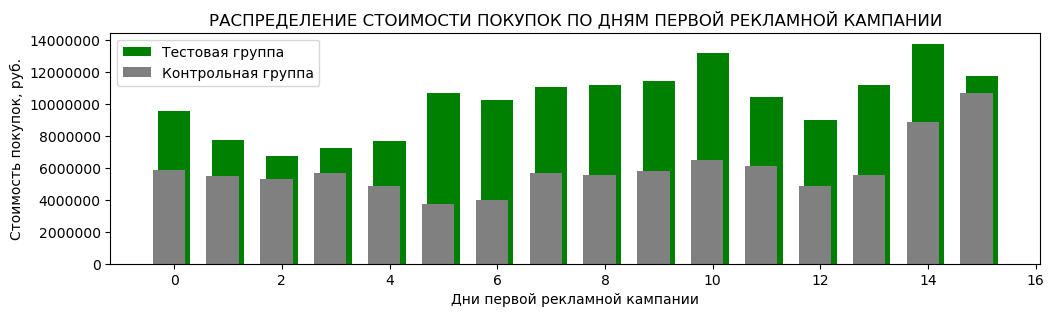

In [10]:
# Визуализируем распределения
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('РАСПРЕДЕЛЕНИЕ СТОИМОСТИ ПОКУПОК ПО ДНЯМ ПЕРВОЙ РЕКЛАМНОЙ КАМПАНИИ')
ax.set_ylabel('Стоимость покупок, руб.')
ax.set_xlabel('Дни первой рекламной кампании')
ax.bar(df_test_cost.index, df_test_cost['cost'], width=0.6,
       color='green', label='Тестовая группа')
ax.bar(df_control_cost.index-0.1, df_control_cost['cost'], width=0.6,
       color='gray', label='Контрольная группа')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.legend();

**Вывод:** Первая рекуламная кампании значительно увеличила стоимость продаж практически в каждый день её проведения.

### 3.2.2. Проверка метрики "Изменение частоты покупок"

In [11]:
# Сформируем выборки по частоте покупок покупателями
df_test_client = df_test.groupby('id').agg({'product': 'count'})
df_control_client = df_control.groupby('id').agg({'product': 'count'})

In [12]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_client['product'], df_control_client['product'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 0.000000%
  - вторая выборка: 0.000000%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 0.000000%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо РАЗЛИЧАЮТСЯ (гипотеза H1)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.0,
  'p-value df2': 0.0},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 4.0493932665489114e-109}}

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


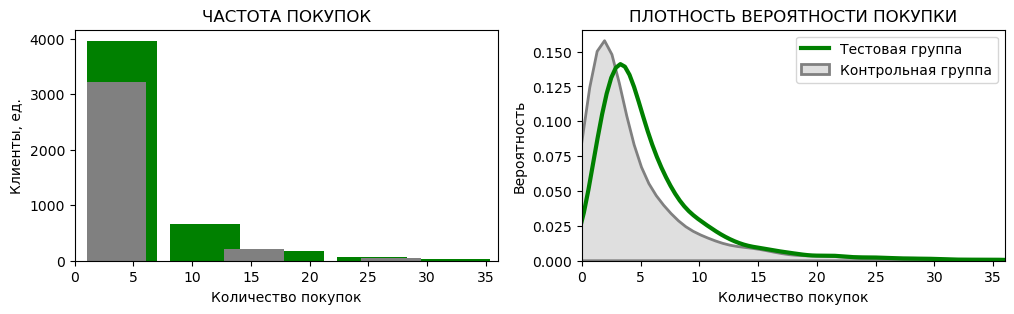

In [14]:
# Визуализируем распределения
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].set_title('ЧАСТОТА ПОКУПОК')
axs[0].set_ylabel('Клиенты, ед.')
axs[0].set_xlabel('Количество покупок')
axs[0].set_xlim(0, 36)
axs[1].set_title('ПЛОТНОСТЬ ВЕРОЯТНОСТИ ПОКУПКИ')
axs[1].set_ylabel('Вероятность')
axs[1].set_xlim(0, 36)
axs[0].hist(df_test_client['product'], color='green',  width=+6)
axs[0].hist(df_control_client['product'], color='gray', width=+5.1)
axs[1] = sns.distplot(df_test_client['product'], hist=False, kde=True, color='green',
                      label='Тестовая группа', kde_kws = {'linewidth': 3})
axs[1] = sns.distplot(df_control_client['product'], hist=False, kde=True, color='gray',
                      label='Контрольная группа', kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel('Количество покупок')
plt.legend();

**Вывод:** Значительно возрасло количество клиентов, совершивших несколько покупок, что свидетельствует об эффективности рекланой кампании, которая привлекает клиентов за повторными покупками. Частота покупок, а следовательно и посещений клиентами магазинов стало более равномерным что позитивно для нагрузки на инфраструктуру обслуживания, так как требует более равного количества обслуживающего персонала в разные периоды работы магазинов. Это также подтверждается возросшей плотностью вероятности покупок (посещений) практисчески у всех клиентов, совершивших 3 и более покупок.

### 3.2.3. Проверка метрики "Увеличение частоты и суммы покупок наиболее состоятельными клиентами"

In [15]:
# Функция разметки данных по возрастным категориям 
# данные из статьи: https://blog.domclick.ru/ipoteka/post/kazhduyu-desyatuyu-ipoteku-v-sbere-berut-molodye-lyudi-analitika-domklik
def age_rank(age):
    if   age < 26: return 1 # меньшие доходы
    elif age < 31: return 2 # средние доходы
    elif age < 41: return 3 # наибольшие доходы
    elif age < 51: return 3 # наибольшие доходы
    elif age < 61: return 2 # средние доходы
    else: return 1 # меншие доходы
    
# Разметим данные 
df_test['age_rank'] = df_test['age'].apply(lambda x: age_rank(x))
df_control['age_rank'] = df_control['age'].apply(lambda x: age_rank(x))

/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_31024/2882487264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['age_rank'] = df_test['age'].apply(lambda x: age_rank(x))
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_31024/2882487264.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control['age_rank'] = df_control['age'].apply(lambda x: age_rank(x))


In [16]:
# Сформируем выборки по возрастным категориям и стоимости покупок
df_test_age = df_test.groupby('age_rank').agg({'cost': 'sum'})
df_control_age = df_control.groupby('age_rank').agg({'cost': 'sum'})

In [17]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_age['cost'], df_control_age['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 6.376481%
  - вторая выборка: 8.279554%
--------------------------------------
 ВЫВОД: Все выборки ПАРАМЕТРИЧЕСКИЕ (распеределены по нормальному закону распределения)

 Проверка равенства Дисперсий выборок тестом Левене
 ЗНАЧЕНИЕ p-value: 75.567725%
--------------------------------------
 ВЫВОД: Дисперсии выборок - РАВНЫЕ


  Для сравнения выборок выбран тест: Т-критерий Стьюдента
 ЗНАЧЕНИЕ p-value при тестировании выборок: 38.020606%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.06376481056213379,
  'p-value df2': 0.08279553800821304},
 'Предпроверка 2': {'name_test': 'Тест Левене', 'p-value': 0.7556772546730324},
 'Результат': {'name_test': 'Т-критерий Стьюдента',
  'p-value': 0.3802060638211032}}

In [18]:
# Сформируем выборки по возрастным категориям и частоте покупок
df_test_age = df_test.groupby('age_rank').agg({'product': 'count'})
df_control_age = df_control.groupby('age_rank').agg({'product': 'count'})

In [19]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_age['product'], df_control_age['product'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 13.581373%
  - вторая выборка: 11.491381%
--------------------------------------
 ВЫВОД: Все выборки ПАРАМЕТРИЧЕСКИЕ (распеределены по нормальному закону распределения)

 Проверка равенства Дисперсий выборок тестом Левене
 ЗНАЧЕНИЕ p-value: 71.835853%
--------------------------------------
 ВЫВОД: Дисперсии выборок - РАВНЫЕ


  Для сравнения выборок выбран тест: Т-критерий Стьюдента
 ЗНАЧЕНИЕ p-value при тестировании выборок: 39.650172%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.13581372797489166,
  'p-value df2': 0.11491381376981735},
 'Предпроверка 2': {'name_test': 'Тест Левене', 'p-value': 0.7183585280977867},
 'Результат': {'name_test': 'Т-критерий Стьюдента',
  'p-value': 0.39650172030040165}}

**Вывод:** проведение рекламной кампании не позволило увеличить стоимость и частоту покупок более состоятельной группой клиентов.

**Общие выводы**:
1) Рекламная кампания мотивировала большее количество клиентов на повторные покупки и значительно увеличила выручку. Это с одно стороны позволит снизить издержк и на инфраструктуру обслуживания клинетов, так как она будет загружена более равномерно, а с другой стороны увеличит доходы за счёт повтороного возврата клиентов, ожидающих дополнительных акций. Для поддержания эффекта целесообразно посторять такие рекламные кампании с сезонной периодичночтью.  
2) Однако, в отношении наиболее состоятельных групп клиентов - в будущих кампаниях рекомендуется акцентировать внимание на конкретных возростных групах, таким образом, чтобы наиболее сильно мотивировать к повторным покупкам группы клиентов со средним и высоким доходом (от 31 до 61 года), которые смогут в будущем совершать более дорогие и более частые покупки.

## 3.3. Оценка второй рекламной кампании

Поскольку вторая рекламная кампания проводилась на отдельной территории (город №1134) её эффективность можно проверить по изменившейся плотности вероятночти покупок покупателями в дни акции в данном городе в сравнении с другими городами

In [21]:
# Получим датасет выбранный для AB тестирования второй маркетенговой компании
df_AB_2 = df_all[~df_all.test.isna()]
df_test = df_AB_2[(df_AB_2.city == 1134) & (df_AB_2.dt.isin([15, 45]))]
df_control = df_AB_2[(df_AB_2.city != 1134) & (df_AB_2.dt.isin([15, 45]))]
# Сформируем выборки по частоте покупок покупателями
df_test_client = df_test.groupby('id').agg({'product': 'count'})
df_control_client = df_control.groupby('id').agg({'product': 'count'})
print(f"Количество покупателей в городе 1134 (тестовая группа): {len(df_test_client)}")
print(f"Количество покупателей в других городах (контрольная группа): {len(df_control_client)}")

Количество покупателей в городе 1134 (тестовая группа): 796
Количество покупателей в других городах (контрольная группа): 1973


Так как вторая рекламна кампания проводилась через канал в конкретном городе, количесвто пользователей которого неконтролируется, то контрольную группу для такой кампании можно выбрать в качестве контрольной группы только покупателей на других территориях. Соответсвенно оценку проведённой рекламной кампании будем проводить по относительному показателю (плотность вероятности покупок), а значит балансировка размеров тестовой и контрольной выборок нецелесообразны.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


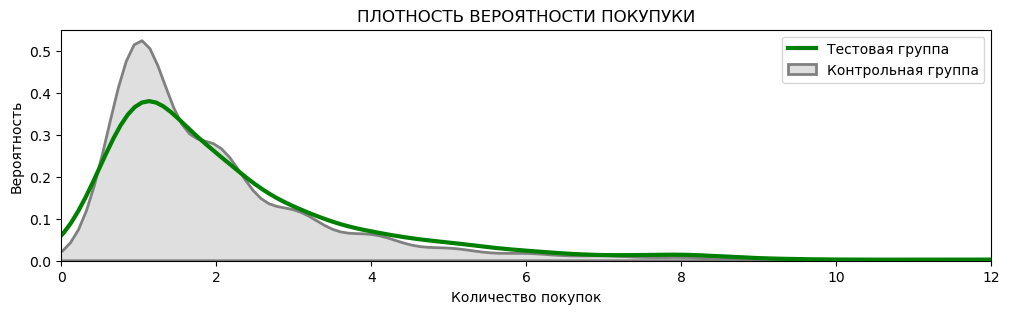

In [22]:
# Визуализируем распределения
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('ПЛОТНОСТЬ ВЕРОЯТНОСТИ ПОКУПУКИ')
ax.set_ylabel('Вероятность')
ax.set_xlim(0, 12)
ax = sns.distplot(df_test_client['product'],hist=False, kde=True, color='green',
                  label='Тестовая группа', kde_kws = {'linewidth': 3})
ax = sns.distplot(df_control_client['product'], hist=False, kde=True, color='gray',
                  label='Контрольная группа', kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel('Количество покупок')
plt.legend();

**Вывод**: Вторая рекламная кампания снизила вероятноть 1 покупки, что является положительным фактором, в случае роста вероятности нескольких покупок, однако этого не произошло. Таким образом вторую рекламную кампанию можно прихзнать неудачной. В будущем её необходимо переработать, например сориентировав на группы с большей доходностью, либо отказаться от её проведения.

# 4. Кластаризация покупателей

## 4.1. Формирование двумерного пространства признаков

In [23]:
# Получим датасет покупателей
df_buyer = df_all.groupby(['id']).\
        agg({'product': 'count', 'cost': 'sum', 'product_sex': 'max',
             'dt': 'nunique', 'gender': 'max', 'age': 'max',
            'education': 'max', 'city': 'max', 'country': 'max', 'personal_coef': 'max',
             'test': 'max'})

In [24]:
# Выделим числовые признаки
df_num = df_buyer[df_buyer.columns[(df_buyer.dtypes == 'int64') | (df_buyer.dtypes == 'float64')]].\
                drop(columns=['test'], axis=1)
# Масштабируем числовые признаки
features = [col for col in df_num.columns]
scaler = StandardScaler()
df_num_sc = pd.DataFrame(data=scaler.fit_transform(df_num[features]), columns=df_num[features].columns)

In [25]:
# Выделим категориальные признаки
df_cat = df_buyer[df_buyer.columns[df_buyer.dtypes == 'object']]
# Закадируем категориальные признаки
oe = OrdinalEncoder()
df_cat_le = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
# Масштабируем числовые признаки
scaler = StandardScaler()
df_cat_sc = pd.DataFrame(data=scaler.fit_transform(df_cat_le), columns=df_cat.columns)

In [26]:
# Объединим числовые и категориальные признаки
df_num_cat_sc = df_num_sc.join(df_cat_sc)
df_num_cat_sc.head(3)

,product,cost,product_sex,dt,gender,age,city,country,personal_coef,education
0,-0.462943,-0.273267,0.526186,-0.724421,-1.150629,-0.164185,0.374836,0.011575,0.780515,0.526402
1,-0.359814,-0.343611,0.526186,-0.444811,0.869090,-0.571248,0.001180,0.011575,-0.446917,0.526402
2,-0.050427,-0.124694,0.526186,-0.165200,-1.150629,-0.245598,0.001180,0.011575,0.780515,0.526402


In [27]:
# Преобразуем пространство признаков в двухмерное
tsne = TSNE(n_components=2)
df_num_cat_sc_tsne = tsne.fit_transform(df_num_cat_sc)
df_num_cat_sc_tsne

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ 31.125528 ,  37.663143 ],
       [ 28.192833 ,  13.338389 ],
       [-30.665276 ,   3.6839654],
       ...,
       [ 43.740715 , -31.41192  ],
       [  9.199274 ,  -2.6852598],
       [ 38.860687 ,   5.7633986]], dtype=float32)

In [28]:
# Добавим координаты двумерного пространства в датасет
df_buyer[['X', 'Y']] = df_num_cat_sc_tsne
df_buyer.head(3)

,product,cost,product_sex,dt,gender,age,education,city,country,personal_coef,test,X,Y
id,,,,,,,,,,,,,
0,3,19897,2.0,2,0.0,36,среднее,1201,32,0.5072,1.0,31.125528,37.663143
3,4,14596,2.0,3,1.0,31,среднее,1134,32,0.4304,0.0,28.192833,13.338389
4,7,31093,2.0,4,0.0,35,среднее,1134,32,0.5072,1.0,-30.665276,3.683965


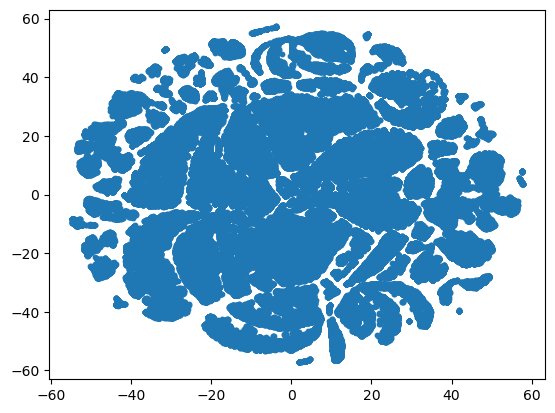

In [29]:
import matplotlib.pyplot as plt
# Визуализируем полученные координаты точек двухмерного пространства
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10);

## 4.2. Кластаризация методом К-средних

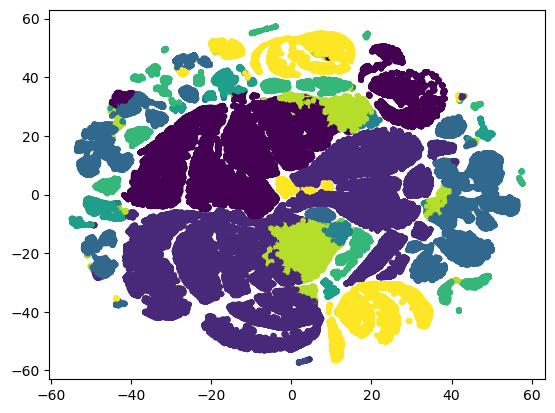

In [30]:
from sklearn.cluster import AgglomerativeClustering, KMeans
# Предварительное разбиение на 10 кластеров
kmeans = KMeans(n_clusters=10, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans.labels_);

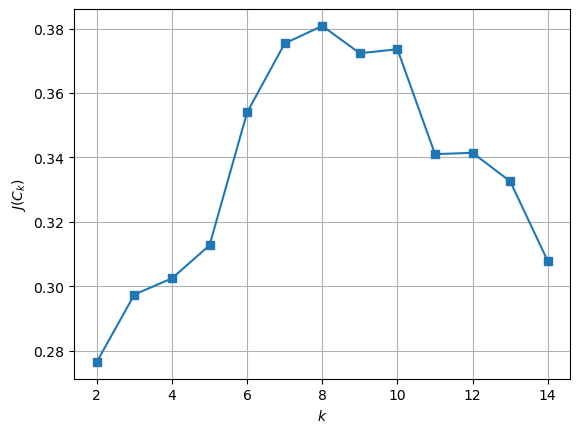

In [31]:
from sklearn.metrics import silhouette_score
# Определение оптимального количества кластеров
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(df_num_sc)
    preds = kmeans.predict(df_num_sc)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_num_sc, preds))

# графическое отображение "колена", характеризующего оптимальное количесвто кластеров
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

Проверим визуально наиболее ярко выраженные участки графика (колени)

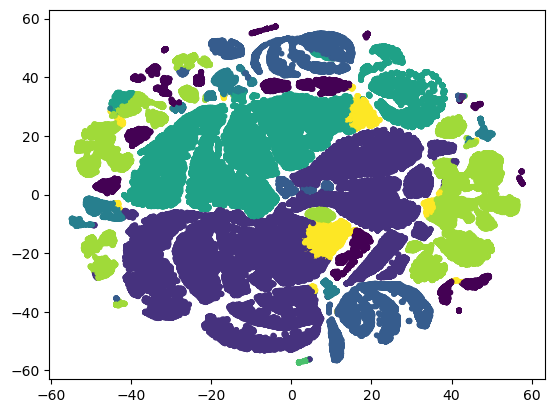

In [37]:
# Разбиение на 8 кластера
kmeans_8 = KMeans(n_clusters=8, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_8.labels_);

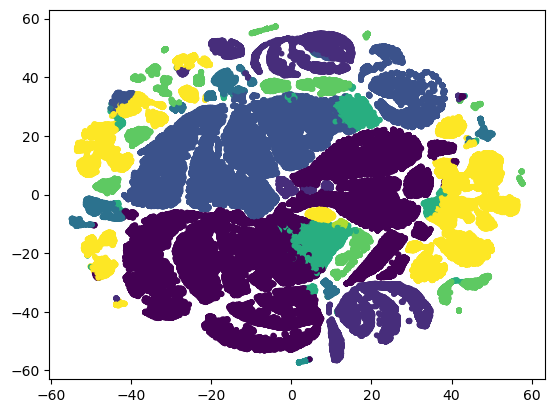

In [38]:
# Разбиение на 9 кластера
kmeans_9 = KMeans(n_clusters=9, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_9.labels_);

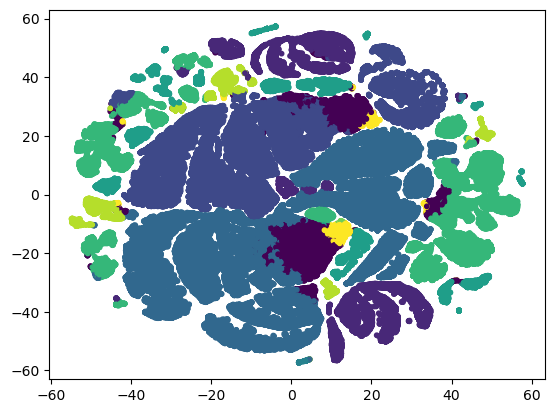

In [39]:
# Разбиение на 10 кластера
kmeans_10 = KMeans(n_clusters=10, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_10.labels_);

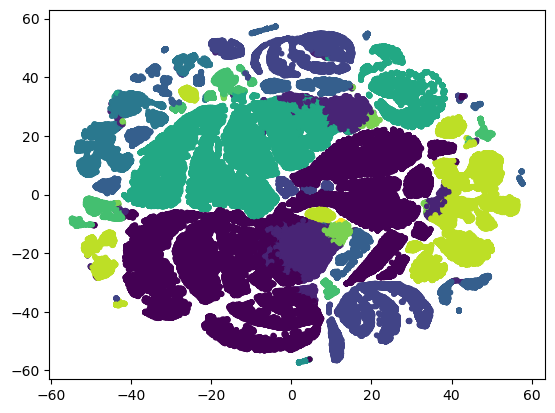

In [41]:
# Разбиение на 11 кластера
kmeans_11 = KMeans(n_clusters=11, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_11.labels_);

**Выводы:** Визуально видно что при увеличении количества кластеров разделения покупателей на явные группы не улучшается. Кроме того при увеличении числа кластеров рвозрастает вероятность ошибочного отнесения точек пространства к кластерам. Таким образом целесообразно выбрать минималное количество кластеров представленное в оптимально выбранном списке "количества кластеров", то есть 8 кластеров.

## 4.3. Определим по каким основным признакам сгруппировались кластеры

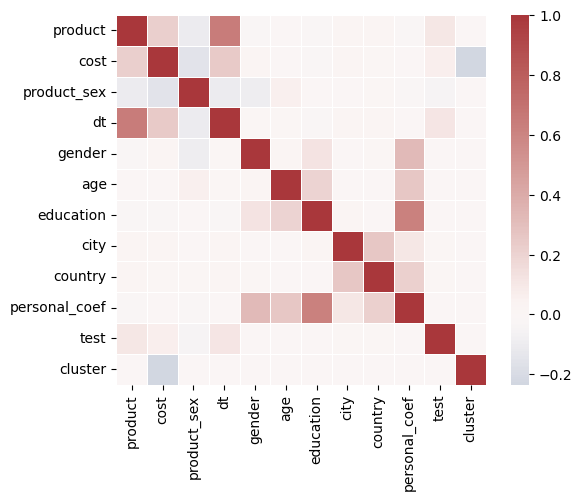

In [43]:
# Сформируем признаки кластеров для датасета
df_cluster = pd.DataFrame(data=kmeans_8.labels_, columns=['cluster'])
# Добавим признаки кластеров в датасет клииентов
df_cluster =df_buyer.join(df_cluster).drop(['X', 'Y'], axis=1)
# Выделим корреляцуии кластеров и иных признаков у покупок
corr_mat = df_cluster.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_mat, cmap='vlag', center=0, square=True, linewidths=.5)
plt.show()

In [44]:
# Выведем коэффициент влияния отдельных поведенческих патернов на отнесение покупок к кластерам 
corr_mat.cluster.sort_values(ascending=False)[1:]

education        0.001429
product_sex      0.001225
gender          -0.000342
personal_coef   -0.000428
product         -0.001304
dt              -0.001327
test            -0.002180
country         -0.004370
age             -0.005184
city            -0.009838
cost            -0.234370
Name: cluster, dtype: float64

**Вывод**: Разбиение на кластеры не выявило признаки, по группе которых можно распределить клиентов таким образом что бы они проявляли одинаковые поведенческие патерны.